<a href="https://colab.research.google.com/github/ElahehSadeghabadi/E2E-Communication-based-on-Deep-Learning/blob/main/3_MIMO_for_Diversity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MIT License

Copyright (c) 2025 ElahehSadeghabadi

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

**Point-to-Point, open-loop, $2\times 1$ MISO with block fading and CSIR to achieve spatial diversity from the following paper:**

[2] T. J. O'Shea, T. Erpek and T. C. Clancy, "*Physical layer deep learning of encodings for the MIMO fading channel,*" 2017 55th Annual Allerton Conference on Communication, Control, and Computing (Allerton), Monticello, IL, USA, 2017, pp. 76-80.

# Setup

In [ ]:
import numpy as np
import tensorflow as tf
from math import ceil, log

# setting seeds for reproducibility
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)

# Resetting the name counters
tf.keras.backend.clear_session()

from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from IPython.display import Image, display

# System Model

Consider a point-to-point $2\times 1$ MISO system:
  - The goal is to design a space-time block code (STBC) to increase robustness and coverage.
  - The same message $s_1,s_2\in\mathcal{M}$ are sent in $T=2$ time slots at one point, and the messages $\hat{s}_1,\hat{s}_2\in\mathcal{M}$ are detected from the received signals in $T=2$ time slots at the other point.
  - Each message has $k$ information bit: $|\mathcal{M}|=M=2^k$.
  - The transmitter has $m_\rm{Tx}=2$ antennas, and the receiver has $m_\rm{Rx}=1$ antennas.
  - For space-time block codes, the same message is encoded in several time slots. Suppose there are $T=2$ time slots, and there are $n$ channel uses for the codeword in each time slot.
  - The codeword at time $t\in\left\{1,\dots,T\right\}$ includes $m_\rm{Tx}$ parallel transmissions in each of $n$ channel uses, and it is represented by $\mathbf{x}_t=\left[\mathbf{x}_{t,1}^T,\dots,\mathbf{x}_{t,n}^T\right]^T$, where $\mathbf{x}_t\in\mathbb{C}^{nm_\rm{Tx}}$ and $\mathbf{x}_{t,i}\in\mathbb{C}^{m_\rm{Tx}},\forall i=1,\dots,n, \forall t=1,\dots,T$.
  - The received signal at time $t$ includes $n$ received signals by $m_\rm{Rx}$ antennas, and it is represented by $\mathbf{y}_t=\left[\mathbf{y}_{t,1},\dots,\mathbf{y}_{t,n}\right]^T$, where $\mathbf{y}_t\in\mathbb{C}^{nm_\rm{Rx}}$ and $\mathbf{y}_{t,i}\in\mathbb{C}^{m_\rm{Rx}},\forall i=1,\dots,n, \forall t = 1,\dots,T$.
  - The encoder maps the messages $s_1,s_2\in\mathcal{M}$ to the $T$ codewords $\mathbf{x}_t,\forall t =1,\dots,T$, and the decoder maps the $T$ received signals $\mathbf{y}_t,\forall t= 1,\dots,T,$ to the messages $\hat{s}_1,\hat{s}_2\in\mathcal{M}$.
  - The channel matrix $\mathbf{H}\in\mathbb{C}^{m_\rm{Tx}\times m_\rm{Rx}}$ is assumed **quasi-static**, which means that the channel matrix is constant during $T$ time slots (including $Tn$ channel uses) and changes for the next $T$ time slots by Rayleigh distribution.
  - There is perfect CSIR, but there is no CSIT.

The system model considered by the paper is represented in Fig. 1.

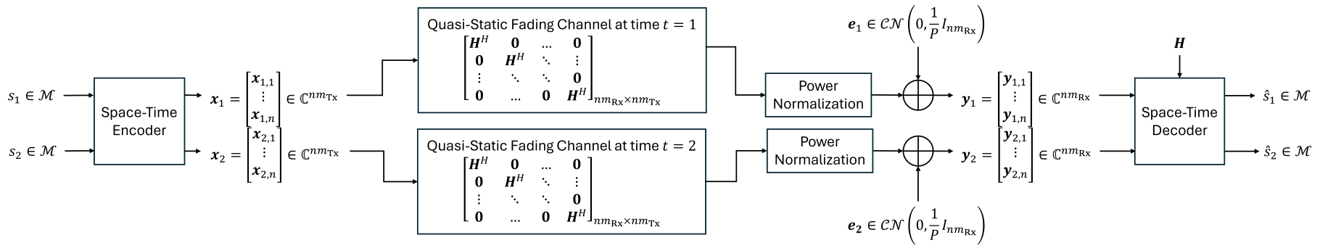

Figure 1: The system model of P2P MIMO system based on STBC for $T=2$ time slots considered in [2, open-loop model], where normalization is applied after the fading channel.

**Note:** In this model, the power normalization is placed after the fading block. However, this consideration seems unrealistic, because power normalization is a transmitter constraint. Probably, the paper ueses a mathematical trick to ensure the gradient can be passed back through the channel and that the loss function operates on a consistent signal power regardless of the channel gain $\mathbf{H}$. Hence, in the following, The system model in Fig. 2 is simulated, where the power normalization is applied as a transmitter constraint. The signal-to-noise ratio (SNR) in this system is $P$, and the power limit for transmission in a channel use is 1.

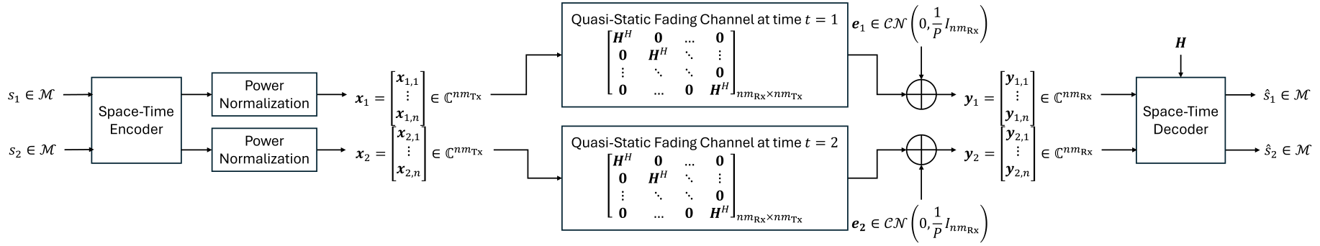

Figure 2: The system model of P2P MIMO system based on STBC for $T=2$ time slots, where the power normalization is applied as a transmitter constraint ensuring $\mathbb{E}\left\{\left\|\mathbf{x}_{t,i}\right\|^2\right\}\leq 1,\forall i = 1,\dots,n,\forall t=1,2$.

## Deep Learning-Based Model

The details of the Encoder and Decoder NNs are not mentioned in [2]. The following architecture in Tables 1 and 2 are applied here.

**Table 1: Encoder Neural Network of P2P $2\times 1$ MISO for STBC of Two Messages in $T$ Time Slots**

|Layer|Output dimensions|Activation|
|:---:|:---------------:|:--------:|
|Message 1 Input (one-hot encoding)|$M$|-|
|$\vdots$|$\vdots$|$\vdots$|
|Message $T$ Input (one-hot encoding)|$M$|-|
|Dense|$128$|`relu`|
|Dense|$128$|`relu`|
|Dense|$2Tnm_\rm{Tx}$|`linear`|
|Normalization (transmitter constraint)|$2Tnm_\rm{Tx}$|-|


**Table 2: Decoder Neural Network of P2P $2\times 1$ MISO for Decoding Two Messages from $T$ Recieved Signals**

|Layer|Output dimensions|Activation|
|:---:|:---------------:|:--------:|
|$T$ Received Signals Input (Real float numbers)|$2Tnm_\rm{Rx}$|-|
|$T$ CSIR Input (Real float numbers)|$2m_{\rm{Tx}}m_{\rm{Rx}}$|-|
|Dense|$128$|`relu`|
|Dense|$128$|`relu`|
|Output1: Estimated Message 1|$M$|`softmax`|
|$\vdots$|$\vdots$|$\vdots$|
|Output$T$: Estimated Message $T$|$M$|`softmax`|

**Note:** The factor 2 in Tables 1 and 2 refers to complex signaling. Each complex number includes 2 real numbers. Also, in the following, $m_\rm{Tx}=2$, $m_\rm{Rx}=1$, $T=2$.

The training parameters applied here are summarized in Table 3:

**Table 3: Training Parameters**  
|Training SNR  in dB|Number of Samples|Epochs|Batch Size|Optimizer|
|:-----------------:|:---------------:|:----:|:--------:|:-------:|
|20|100_000|30|1024|`Adam(learning_rate=0.001)`|

# Creating and Training Models by TensorFlow and Keras

Before going forward to creating models by TensorFlow and Keras, don't forget to run the methods for transmitter constraint and for applying fading channel!

## Normalization and Fading Channel Methods

In [ ]:
def apply_power_norm(x, power_lim = 1.0):

    # Power normalization:------------------------------------------------------
    # Applying power constraint of power_lim per transmission in a channel use
    avg_power = tf.reduce_mean(tf.square(x), axis=0)
    scale_factors = tf.where(avg_power > (power_lim/2),
                            tf.math.sqrt((power_lim/2) / avg_power),
                            tf.ones_like(avg_power))
    y = x * tf.expand_dims(scale_factors, axis=0)
    #---------------------------------------------------------------------------
    return y

In [ ]:
def apply_rayleigh(x):

    # Encoded Signal at Time t=1
    x1_t1_real = x[...,:n]
    x1_t1_complex = x[...,n:2*n]
    x2_t1_real = x[...,2*n:3*n]
    x2_t1_complex = x[..., 3*n:4*n]

    # Encoded Signal at Time t=2
    x1_t2_real = x[..., 4*n:5*n]
    x1_t2_complex = x[...,5*n:6*n]
    x2_t2_real = x[...,6*n:7*n]
    x2_t2_complex = x[...,7*n:8*n]

    # Channel
    """
    The channel matrix is assumed to be constant during two codeword transmissions and it changes for the next STBC by Rayleigh distribution.
    Rx1-Tx1: real: h[0], complex: h[1]
    Rx1-Tx2: real: h[2], complex: h[3]
    """
    h = x[...,8*n:]
    h11_real = tf.expand_dims(h[:,0],axis = 1)
    h11_complex = tf.expand_dims(h[:,1],axis = 1)
    h12_real = tf.expand_dims(h[:,2],axis = 1)
    h12_complex = tf.expand_dims(h[:,3],axis = 1)

    # Applying channel:---------------------------------------------------------
    # Time slot 1
    y_t1_real = h11_real * x1_t1_real - h11_complex * x1_t1_complex + h12_real * x2_t1_real - h12_complex * x2_t1_complex
    y_t1_complex = h11_complex * x1_t1_real + h11_real * x1_t1_complex + h12_complex * x2_t1_real + h12_real * x2_t1_complex
    # Time slot 2
    y_t2_real = h11_real * x1_t2_real - h11_complex * x1_t2_complex + h12_real * x2_t2_real - h12_complex * x2_t2_complex
    y_t2_complex = h11_complex * x1_t2_real + h11_real * x1_t2_complex + h12_complex * x2_t2_real + h12_real * x2_t2_complex
    #---------------------------------------------------------------------------
    return tf.concat([y_t1_real, y_t1_complex, y_t2_real, y_t2_complex], axis = -1)

## Creating and Training Tx and Rx Models

In [ ]:
def MIMO_2by1_diversity(n, k, training_SNR_dB = 20, n_samples = 100_000, epochs = 30, batch_size = 1024):
  # We assume complex signaling here.

  tf.keras.backend.clear_session()# Resetting the name counters

  M = 2**k
  R = k/n
  power_limit = 1.0
  snr = 10**(training_SNR_dB/10)
  noise_std = np.sqrt(0.5/snr)
  # Messages====================================================================
  T = 2
  m_tx = 2
  m_rx = 1

  # Channel
  H = tf.random.normal(shape = [n_samples,m_tx*m_rx*2], mean=0.0, stddev=np.sqrt(0.5), dtype=tf.dtypes.float32)

  # Message indexing:
  messages1 = tf.random.uniform(shape=(n_samples,), minval=0, maxval=M, dtype=tf.int32)
  messages2 = tf.random.uniform(shape=(n_samples,), minval=0, maxval=M, dtype=tf.int32)

  # One-hot encoding:
  X_train1 = tf.one_hot(messages1, M)# messages in the first input of Tx
  X_train2 = tf.one_hot(messages2, M)# messages in the second input of Tx

  # Creating the model==========================================================
  # Tx:-------------------------------------------------------------------------
  tx_input1 = tf.keras.layers.Input(shape=[M,]) # Input1-time slot 1
  tx_input2 = tf.keras.layers.Input(shape=[M,]) # Input2-time slot 2

  tx_input = tf.keras.layers.Concatenate()([tx_input1, tx_input2])
  tx_output = tf.keras.layers.Dense(128, activation='relu')(tx_input)
  tx_output = tf.keras.layers.Dense(128, activation='relu')(tx_output)
  tx_output = tf.keras.layers.Dense(2*T*m_tx*n)(tx_output)
  tx_output = tf.keras.layers.Lambda(lambda x: apply_power_norm(x, power_lim = power_limit), output_shape=(2*T*m_tx*n,))(tx_output)

  tx_model = tf.keras.Model(inputs=[tx_input1, tx_input2], outputs=tx_output)

  # Reyleigh channel and normalization:-----------------------------------------
  channel_input = tf.keras.layers.Input(shape=[2*m_tx*m_rx,]) # channel
  reyleigh_input = tf.keras.layers.Concatenate()([tx_output, channel_input])
  reyleigh_output = tf.keras.layers.Lambda(lambda x: apply_rayleigh(x), output_shape=(2*T*m_rx*n,))(reyleigh_input)

  ch_reyleigh = tf.keras.Model(inputs = [tx_output, channel_input], outputs = reyleigh_output)

  # AWGN------------------------------------------------------------------------
  ch_out = tf.keras.layers.GaussianNoise(noise_std)(reyleigh_output)

  # Rx--------------------------------------------------------------------------
  rx_input = tf.keras.layers.Concatenate()([ch_out, channel_input])
  rx_output = tf.keras.layers.Dense(128, activation='relu')(rx_input)
  rx_output = tf.keras.layers.Dense(128, activation='relu')(rx_output)
  rx_output1 = tf.keras.layers.Dense(M, activation='softmax')(rx_output)
  rx_output2 = tf.keras.layers.Dense(M, activation='softmax')(rx_output)

  rx_model = tf.keras.Model(inputs=[ch_out, channel_input], outputs=[rx_output1, rx_output2])

  # E2E model-------------------------------------------------------------------
  e2e_model = tf.keras.Model(inputs=[tx_input1, tx_input2, channel_input], outputs=[rx_output1, rx_output2])
  # Compiling===================================================================
  e2e_model.compile(loss = ["categorical_crossentropy","categorical_crossentropy"], optimizer = tf.keras.optimizers.AdamW(learning_rate=0.001))
  # Training====================================================================
  e2e_model.fit((X_train1,X_train2,H),(X_train1,X_train2), epochs = epochs, batch_size = batch_size)
  return tx_model, ch_reyleigh, rx_model

# Evaluating

## BLER

Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - dense_5_loss: 1.1892 - dense_6_loss: 1.1672 - loss: 2.3564
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - dense_5_loss: 0.2359 - dense_6_loss: 0.2300 - loss: 0.4659
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - dense_5_loss: 0.0799 - dense_6_loss: 0.0752 - loss: 0.1551
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - dense_5_loss: 0.0501 - dense_6_loss: 0.0487 - loss: 0.0987
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - dense_5_loss: 0.0373 - dense_6_loss: 0.0373 - loss: 0.0746
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - dense_5_loss: 0.0314 - dense_6_loss: 0.0306 - loss: 0.0620
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - dense_5_loss: 0.0270 - dense_6_loss: 0.0269 - loss: 0.0539
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - dense_5_loss: 0.0233 - dense_6_loss: 0.0234 - loss: 0.0467
Epoch 9/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - dense_5_loss: 0.0209 - dense_6_loss: 0.0205 - loss:

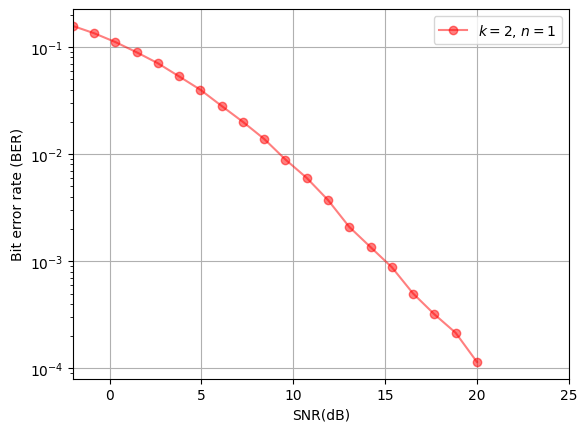

In [ ]:
tf.keras.backend.clear_session()# Resetting the name counters
# setting seeds for reproducibility
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
# System Model Parameter--------------------------------------------------------
n = 1 # Codeword length
k = 2 # Number of information bits in each of the two messages
M = 2**k # Codebook size for each message
T = 2 # Number of time slots
m_tx = 2 # Number of transmit antennas
m_rx = 1 # Number of receive antennas

# Creating and Training Tx and Rx Model=========================================
training_SNR_dB = 20
n_samples = 100_000
epochs = 30
batch_size = 1024
tx_model, ch_reyleigh, rx_model = MIMO_2by1_diversity(n = n, k = k, training_SNR_dB = training_SNR_dB, n_samples = n_samples, epochs = epochs, batch_size = batch_size)

# Evaluting BLER================================================================
n_samples_eval = 50_000
# Channel
H = tf.random.normal(shape = [n_samples_eval,m_tx*m_rx*2], mean=0.0, stddev=np.sqrt(0.5), dtype=tf.dtypes.float32)
# Messages----------------------------------------------------------------------
# Message indexing:
messages1 = tf.random.uniform(shape=(n_samples_eval,), minval=0, maxval=M, dtype=tf.int32)
messages2 = tf.random.uniform(shape=(n_samples_eval,), minval=0, maxval=M, dtype=tf.int32)
messages = np.concatenate((messages1, messages2), axis = 0)
# One-hot encoding:
X1 = tf.one_hot(messages1, M)# messages in the first input of Tx
X2 = tf.one_hot(messages2, M)# messages in the second input of Tx
# Iterating the values of Eb_N0-------------------------------------------------
SNR_num = 20
SNR_dB = np.linspace(-2,20,SNR_num)
BLER = np.zeros(SNR_num,)

for i in range(SNR_num):
  # Tx
  tx_signal = tx_model((X1,X2))

  # Rayleigh Channel
  ch_rayleigh_signal = ch_reyleigh((tx_signal,H))

  # AWGN
  snr = 10**(SNR_dB[i]/10)
  noise_std = np.sqrt(0.5/(snr))
  ch_out = ch_rayleigh_signal + tf.random.normal(shape=tf.shape(ch_rayleigh_signal), mean=0.0, stddev=noise_std)

  # Rx:
  X_hat1, X_hat2 = rx_model((ch_out,H))
  messages_hat1 = np.argmax(X_hat1, axis = -1)
  messages_hat2 = np.argmax(X_hat2, axis = -1)
  messages_hat = np.concatenate((messages_hat1, messages_hat2), axis = 0)
  # Counting the number of false prediction:------------------------------------
  BLER[i] = np.count_nonzero(messages_hat != messages) / (2*n_samples_eval)
  #print(BLER[i])

# BER Plot=====================================================================
# Assuming that an error in a block is most likely due to one bit of error, BER is approximated as BLER/k
BER_plot, = plt.plot(SNR_dB, BLER/k, 'r-o', label = r'$k=$' + f'{k}, ' + r'$n=$' + f'{n}')
BER_plot.set_alpha(0.5)
plt.legend(loc = 'best')
plt.xlabel("SNR(dB)")
plt.ylabel("Bit error rate (BER)")
plt.xlim([-2,25])
plt.yscale("log")
plt.grid()
plt.savefig(f"BLER_2by1MIMO.png")

The slope of the simulated BER curve here is more similar to the Alamouti curve represented in [2, Figure 5], though it provides better BER performance in comparison to the Alamouti curve. The difference between the results here and the curve labeled "Learned $2\times1$" in [2,Figure 5] can be due to the difference in:
-  Considerations for power normalization,
-  Deep learning architecture of encoder and decoder,
-  Training hyperparameters, and
-  Calculation of BER.

**Note:** Here, BER is not calculated. Rather, it is approximated by BLER divided by the number of bits in a message, which is based on the assumption that an error in a block is most likely due to one bit of error.


## Visualizing Codewords Constellations

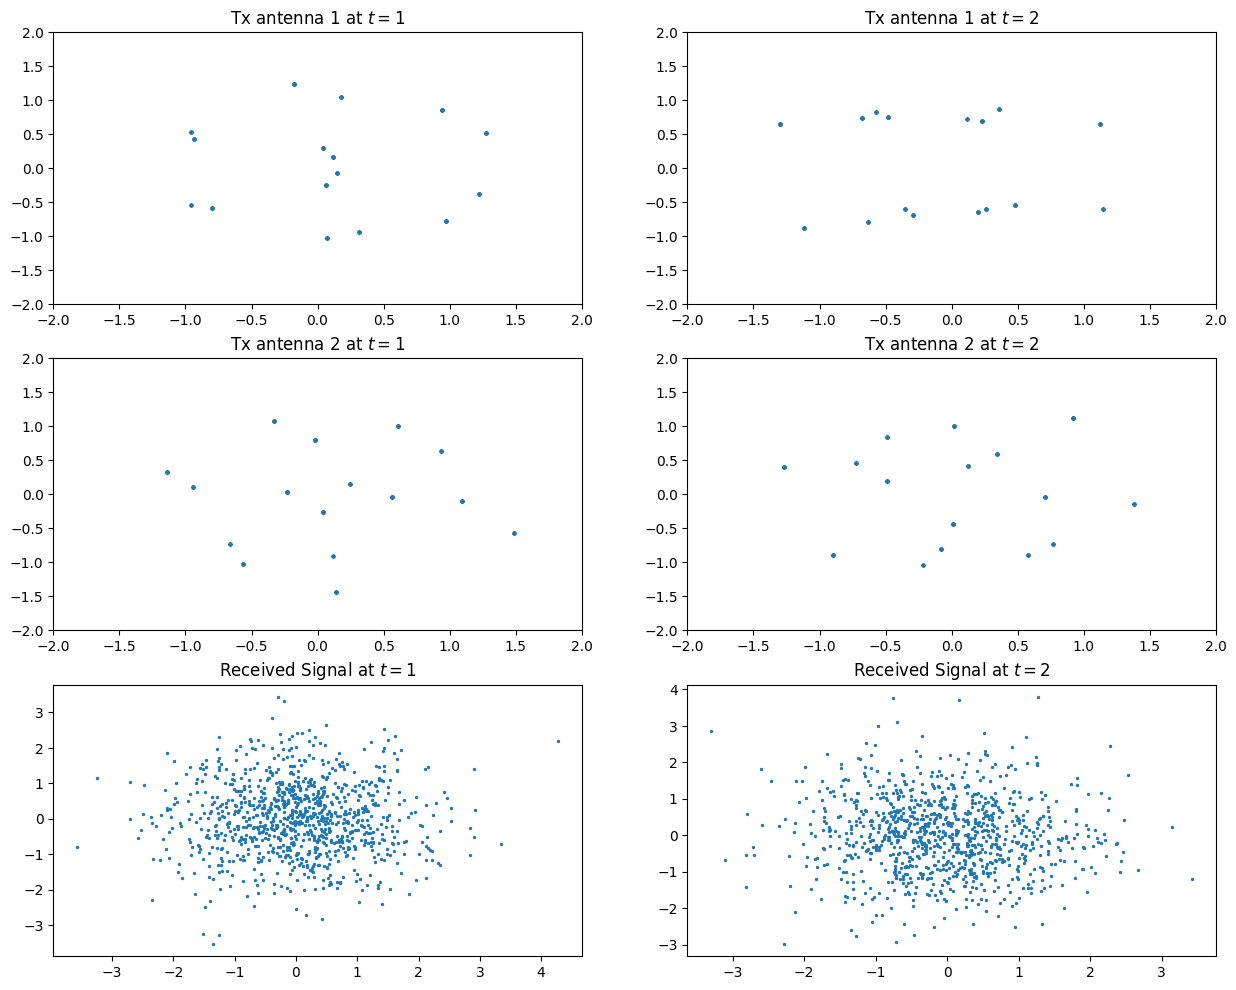

In [ ]:
# setting seeds for reproducibility
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
# System Model Parameter--------------------------------------------------------
n = 1 # Codeword length
k = 2 # Number of information bits in each of the two messages
M = 2**k # Codebook size for each message
T = 2 # Number of time slots
m_tx = 2 # Number of transmit antennas
m_rx = 1 # Number of receive antennas

SNR_dB_symbol = 20
snr = 10**(SNR_dB_symbol/10)
noise_std = np.sqrt(0.5/(snr))
n_symbols = 1_000
# Channel=======================================================================
H = tf.random.normal(shape = [n_symbols,m_tx*m_rx*2], mean=0.0, stddev=np.sqrt(0.5), dtype=tf.dtypes.float32)
# Messages======================================================================
# Message indexing:
messages1 = tf.random.uniform(shape=(n_symbols,), minval=0, maxval=M, dtype=tf.int32)
messages2 = tf.random.uniform(shape=(n_symbols,), minval=0, maxval=M, dtype=tf.int32)

# One-hot encoding:
X_train1 = tf.one_hot(messages1, M)# messages in the first input of Tx
X_train2 = tf.one_hot(messages2, M)# messages in the second input of Tx
# Symbols=======================================================================
# --- Tx Symbols ---
tx_symbols = tx_model((X_train1,X_train2))

# Encoded Signal at Time t=1
x1_t1_real = tx_symbols[...,:n]
x1_t1_complex = tx_symbols[...,n:2*n]
x2_t1_real = tx_symbols[...,2*n:3*n]
x2_t1_complex = tx_symbols[..., 3*n:4*n]

# Encoded Signal at Time t=2
x1_t2_real = tx_symbols[..., 4*n:5*n]
x1_t2_complex = tx_symbols[...,5*n:6*n]
x2_t2_real = tx_symbols[...,6*n:7*n]
x2_t2_complex = tx_symbols[...,7*n:8*n]

# --- Rx Symbols ---
rx_symbols = ch_reyleigh((tx_symbols,H))
rx_symbols = rx_symbols + tf.random.normal(shape = rx_symbols.shape, mean=0.0, stddev=noise_std, dtype=tf.dtypes.float32)

# Received Signals at Time t=1
y_t1_real = rx_symbols[...,:n]
y_t1_complex = rx_symbols[...,n:2*n]

# Received Signals at Time t=2
y_t2_real = rx_symbols[...,2*n:3*n]
y_t2_complex = rx_symbols[..., 3*n:4*n]
# Plots=========================================================================
plt.figure(figsize=(15, 12))
plt.subplot(3,2,1)
plt.scatter(x1_t1_real,x1_t1_complex, s = 2)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title('Tx antenna 1 at ' + r'$t=1$')
plt.subplot(3,2,2)
plt.scatter(x1_t2_real,x1_t2_complex, s = 2)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title('Tx antenna 1 at ' + r'$t=2$')
plt.subplot(3,2,3)
plt.scatter(x2_t1_real,x2_t1_complex, s = 2)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title('Tx antenna 2 at ' + r'$t=1$')
plt.subplot(3,2,4)
plt.scatter(x2_t2_real,x2_t2_complex, s = 2)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title('Tx antenna 2 at ' + r'$t=2$')
plt.subplot(3,2,5)
plt.scatter(y_t1_real,y_t1_complex, s = 2)
#plt.xlim(-3,3)
#plt.ylim(-3,3)
plt.title('Received Signal at ' + r'$t=1$')
plt.subplot(3,2,6)
plt.scatter(y_t2_real,y_t2_complex, s = 2)
#plt.xlim(-3,3)
#plt.ylim(-3,3)
plt.title('Received Signal at ' + r'$t=2$')
plt.savefig(f"Symbols_2by1MIMO.png")

The symbols represented here shows that the learned system uses both transmit antennas for transmission, which is in contrast to [2, Figure 6], where the power of the signal for the second transmit antenna is approximately zero.